# **Tesing "One Stop Shop" Packages**

In [1]:
import itertools
import pandas as pd
import numpy as np
from random import gauss

from sklearn.metrics import mean_squared_error as mse
from sklearn.linear_model import Ridge

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

import warnings 
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
# Setup
data = 'data/'

class CFG:
    img_dim1 = 10
    img_dim2 = 6
    fontsize = 8
    marker = 1.5
    lines = 1.3

# plt.rcParams.keys() to list params
# adjust the parameters for displayed figures    
plt.rcParams.update({'figure.figsize': (CFG.img_dim1,CFG.img_dim2),
                     'font.size': (CFG.fontsize),
                     'lines.markersize': (CFG.marker),
                     'lines.linewidth': (CFG.lines)})  

In [3]:
# Func to calculate RMSE
def rmse(x, y):
    return (np.round(np.sqrt(mse(x, y)), 4))

In [4]:
# Get data from kaggle
from pathlib import Path
import zipfile
cred_path = Path('~/.kaggle/kaggle.json').expanduser()

def download_data(dataset, path, comp_check=True):
    os.makedirs(path, exist_ok=True)
    if any(Path(path).glob("*.zip")) or any(Path(path).iterdir()):
        print(f"Files already exist in '{path}'. Skipping download.")
        return
    if comp_check: kaggle_call = f"kaggle competitions download -c {dataset} -p {path}"
    else         : kaggle_call = f"kaggle datasets download -d {dataset} -p {path} --unzip"
    subprocess.run(kaggle_call, shell=True, check=True)
    for file in Path(path).glob("*.zip"):
        with zipfile.ZipFile(file, 'r') as zip_ref:
            zip_ref.extractall(path)
        print(f"Extracted {file}")
        file.unlink()
    print(f"Dataset '{dataset}' has been downloaded to '{path}'")

## **Prep Data**

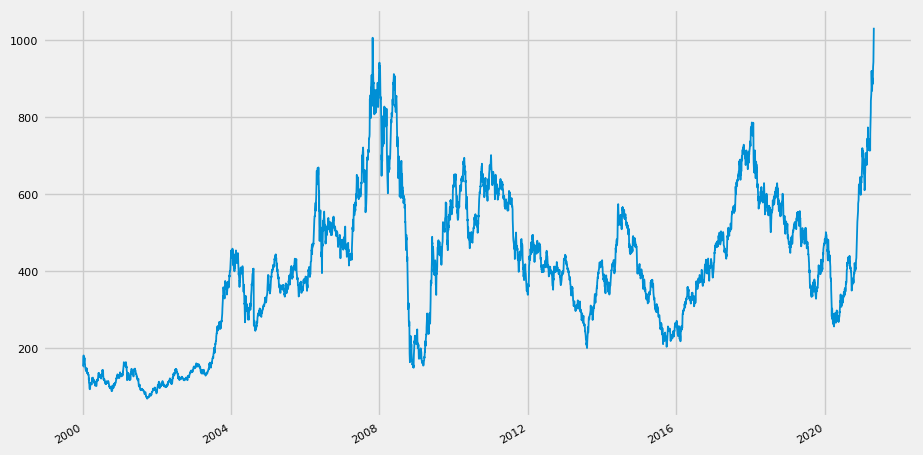

In [5]:
stock = 'TATASTEEL'

df = pd.read_csv('data/nifty50-stocks/'+ stock + '.csv', usecols=['Date', 'VWAP'])
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df.VWAP.plot(xlabel = '');

In [6]:
# Split into training  and test sets 
df_train, df_test = df.iloc[df.index <= '2021-01-01'], df.iloc[df.index > '2021-01-01']
df_train.shape, df_test.shape

((5227, 1), (79, 1))

## **AutoTS**

**-PROSE-**

In [7]:
from autots.models.model_list import model_lists
from autots import AutoTS

In [8]:
# Listing available model classes
model_lists.keys()

dict_keys(['all', 'default', 'fast', 'superfast', 'parallel', 'fast_parallel', 'fast_parallel_no_arima', 'scalable', 'probabilistic', 'multivariate', 'univariate', 'no_params', 'recombination_approved', 'no_shared', 'no_shared_fast', 'experimental', 'slow', 'gpu', 'regressor', 'best', 'motifs', 'all_result_path', 'regressions', 'all_pragmatic', 'update_fit'])

In [9]:
# Complete list of models
model_lists['all']

['ConstantNaive',
 'LastValueNaive',
 'AverageValueNaive',
 'GLS',
 'GLM',
 'ETS',
 'ARIMA',
 'FBProphet',
 'RollingRegression',
 'GluonTS',
 'SeasonalNaive',
 'UnobservedComponents',
 'VECM',
 'DynamicFactor',
 'MotifSimulation',
 'WindowRegression',
 'VAR',
 'DatepartRegression',
 'UnivariateRegression',
 'UnivariateMotif',
 'MultivariateMotif',
 'NVAR',
 'MultivariateRegression',
 'SectionalMotif',
 'Theta',
 'ARDL',
 'NeuralProphet',
 'DynamicFactorMQ',
 'PytorchForecasting',
 'ARCH',
 'RRVAR',
 'MAR',
 'TMF',
 'LATC',
 'KalmanStateSpace',
 'MetricMotif',
 'Cassandra',
 'SeasonalityMotif',
 'MLEnsemble',
 'PreprocessingRegression',
 'FFT',
 'BallTreeMultivariateMotif',
 'TiDE',
 'NeuralForecast',
 'DMD']

In [10]:
# Testing the Theta model
model = AutoTS(
    forecast_length = len(df_test),
    frequency = 'infer',
    prediction_interval= 0.9,
    ensemble = 'simple', # single best model
    model_list = ['GLM', 'Theta', 'ETS'],
    transformer_list='superfast',
    drop_most_recent = 1,
    max_generations = 5,
    num_validations = 2,
    validation_method = 'backwards'    
)

model = model.fit(df_train, 
                  #date_col= None, # 'datetime' if long else None,
                  #value_col= None,#  'value' if long else None,
                  #id_col= None,   #'series_id' if long else None,
                 )

Using 5 cpus for n_jobs.
Data frequency is: B, used frequency is: B
Model Number: 1 with model ETS in generation 0 of 5
Model Number: 2 with model ETS in generation 0 of 5
Model Number: 3 with model GLM in generation 0 of 5
Model Number: 4 with model GLM in generation 0 of 5
Model Number: 5 with model ETS in generation 0 of 5
Model Number: 6 with model Theta in generation 0 of 5
Model Number: 7 with model GLM in generation 0 of 5
Template Eval Error: ValueError('The first guess on the deviance function returned a nan.  This could be a boundary  problem and should be reported.') in model 7 in generation 0: GLM
Model Number: 8 with model Theta in generation 0 of 5


/home/bchaudhry/miniforge3/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "
/home/bchaudhry/miniforge3/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1406: RuntimeWarning: invalid value encountered in log
  resid_dev -= endog_alpha * np.log(endog_alpha / mu_alpha)


Model Number: 9 with model ETS in generation 0 of 5
Model Number: 10 with model Theta in generation 0 of 5
Model Number: 11 with model Theta in generation 0 of 5
Model Number: 12 with model ETS in generation 0 of 5
Model Number: 13 with model GLM in generation 0 of 5
Template Eval Error: UnboundLocalError("local variable 'Xf' referenced before assignment") in model 13 in generation 0: GLM
Model Number: 14 with model GLM in generation 0 of 5
Model Number: 15 with model GLM in generation 0 of 5
Template Eval Error: ValueError('regression_type=user and no future_regressor passed') in model 15 in generation 0: GLM
Model Number: 16 with model Theta in generation 0 of 5
Model Number: 17 with model GLM in generation 0 of 5
Template Eval Error: UnboundLocalError("local variable 'Xf' referenced before assignment") in model 17 in generation 0: GLM
Model Number: 18 with model ETS in generation 0 of 5
Model Number: 19 with model ETS in generation 0 of 5
Model Number: 20 with model ETS in generatio

/home/bchaudhry/miniforge3/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
/home/bchaudhry/miniforge3/lib/python3.10/site-packages/statsmodels/genmod/generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/home/bchaudhry/miniforge3/lib/python3.10/site-packages/statsmodels/genmod/generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/home/bchaudhry/miniforge3/lib/python3.10/site-packages/statsmodels/genmod/generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/home/bchaudhry/miniforge3/lib/python3.10/s

Model Number: 69 with model ETS in generation 4 of 5
Model Number: 70 with model Theta in generation 4 of 5
Model Number: 71 with model ETS in generation 4 of 5
Model Number: 72 with model GLM in generation 4 of 5
Model Number: 73 with model Theta in generation 4 of 5


/home/bchaudhry/miniforge3/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


Model Number: 74 with model Theta in generation 4 of 5
Model Number: 75 with model GLM in generation 4 of 5
Model Number: 76 with model Theta in generation 4 of 5
Model Number: 77 with model Theta in generation 4 of 5
Model Number: 78 with model Theta in generation 4 of 5
Model Number: 79 with model Theta in generation 4 of 5
Model Number: 80 with model Theta in generation 4 of 5
Model Number: 81 with model GLM in generation 4 of 5
New Generation: 5 of 5
Model Number: 82 with model Theta in generation 5 of 5


/home/bchaudhry/miniforge3/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


Model Number: 83 with model Theta in generation 5 of 5
Model Number: 84 with model Theta in generation 5 of 5
Model Number: 85 with model Theta in generation 5 of 5
Model Number: 86 with model ETS in generation 5 of 5
Model Number: 87 with model ETS in generation 5 of 5
Model Number: 88 with model ETS in generation 5 of 5
Model Number: 89 with model ETS in generation 5 of 5
Model Number: 90 with model ETS in generation 5 of 5
Model Number: 91 with model Theta in generation 5 of 5
Model Number: 92 with model Theta in generation 5 of 5
Model Number: 93 with model ETS in generation 5 of 5
Model Number: 94 with model Ensemble in generation 6 of Ensembles
Model Number: 95 with model Ensemble in generation 6 of Ensembles
Model Number: 96 with model Ensemble in generation 6 of Ensembles
Model Number: 97 with model Ensemble in generation 6 of Ensembles
Model Number: 98 with model Ensemble in generation 6 of Ensembles
Model Number: 99 with model Ensemble in generation 6 of Ensembles


/home/bchaudhry/miniforge3/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


Model Number: 100 with model Ensemble in generation 6 of Ensembles


/home/bchaudhry/miniforge3/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
/home/bchaudhry/miniforge3/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


Validation Round: 1
Model Number: 1 of 15 with model Theta for Validation 1
📈 1 - Theta with avg smape 74.29: 
Model Number: 2 of 15 with model Ensemble for Validation 1
2 - Ensemble with avg smape 74.3: 
Model Number: 3 of 15 with model Theta for Validation 1
3 - Theta with avg smape 74.29: 
Model Number: 4 of 15 with model Ensemble for Validation 1
4 - Ensemble with avg smape 74.29: 
Model Number: 5 of 15 with model Theta for Validation 1
5 - Theta with avg smape 74.31: 
Model Number: 6 of 15 with model Ensemble for Validation 1
6 - Ensemble with avg smape 74.3: 
Model Number: 7 of 15 with model Theta for Validation 1
7 - Theta with avg smape 75.54: 
Model Number: 8 of 15 with model Theta for Validation 1
📈 8 - Theta with avg smape 54.57: 
Model Number: 9 of 15 with model Theta for Validation 1
📈 9 - Theta with avg smape 54.26: 
Model Number: 10 of 15 with model Ensemble for Validation 1
📈 10 - Ensemble with avg smape 46.24: 
Model Number: 11 of 15 with model Ensemble for Validation 

/home/bchaudhry/miniforge3/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
/home/bchaudhry/miniforge3/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


📈 11 - Ensemble with avg smape 39.61: 
Model Number: 12 of 15 with model Ensemble for Validation 2
12 - Ensemble with avg smape 39.61: 
Model Number: 13 of 15 with model ETS for Validation 2
📈 13 - ETS with avg smape 38.44: 
Model Number: 14 of 15 with model ETS for Validation 2


/home/bchaudhry/miniforge3/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


14 - ETS with avg smape 40.15: 
Model Number: 15 of 15 with model ETS for Validation 2
📈 15 - ETS with avg smape 37.74: 
Model Number: 131 with model Ensemble in generation 7 of Ensembles


/home/bchaudhry/miniforge3/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
/home/bchaudhry/miniforge3/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


Model Number: 132 with model Ensemble in generation 7 of Ensembles


/home/bchaudhry/miniforge3/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
/home/bchaudhry/miniforge3/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


Model Number: 133 with model Ensemble in generation 7 of Ensembles


/home/bchaudhry/miniforge3/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
/home/bchaudhry/miniforge3/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
/home/bchaudhry/miniforge3/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


Model Number: 134 with model Ensemble in generation 7 of Ensembles


/home/bchaudhry/miniforge3/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
/home/bchaudhry/miniforge3/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


Model Number: 135 with model Ensemble in generation 7 of Ensembles


/home/bchaudhry/miniforge3/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
/home/bchaudhry/miniforge3/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


Model Number: 136 with model Ensemble in generation 7 of Ensembles
Model Number: 137 with model Ensemble in generation 7 of Ensembles


/home/bchaudhry/miniforge3/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
/home/bchaudhry/miniforge3/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


Validation Round: 1
Model Number: 1 of 7 with model Ensemble for Validation 1
📈 1 - Ensemble with avg smape 34.89: 
Model Number: 2 of 7 with model Ensemble for Validation 1
2 - Ensemble with avg smape 39.18: 
Model Number: 3 of 7 with model Ensemble for Validation 1
3 - Ensemble with avg smape 35.41: 
Model Number: 4 of 7 with model Ensemble for Validation 1
4 - Ensemble with avg smape 40.8: 
Model Number: 5 of 7 with model Ensemble for Validation 1
5 - Ensemble with avg smape 41.97: 
Model Number: 6 of 7 with model Ensemble for Validation 1
6 - Ensemble with avg smape 40.56: 
Model Number: 7 of 7 with model Ensemble for Validation 1
7 - Ensemble with avg smape 41.97: 
Validation Round: 2
Model Number: 1 of 7 with model Ensemble for Validation 2


/home/bchaudhry/miniforge3/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
/home/bchaudhry/miniforge3/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


📈 1 - Ensemble with avg smape 38.99: 
Model Number: 2 of 7 with model Ensemble for Validation 2


/home/bchaudhry/miniforge3/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
/home/bchaudhry/miniforge3/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


2 - Ensemble with avg smape 39.61: 
Model Number: 3 of 7 with model Ensemble for Validation 2


/home/bchaudhry/miniforge3/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
/home/bchaudhry/miniforge3/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
/home/bchaudhry/miniforge3/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


3 - Ensemble with avg smape 39.22: 
Model Number: 4 of 7 with model Ensemble for Validation 2


/home/bchaudhry/miniforge3/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
/home/bchaudhry/miniforge3/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


4 - Ensemble with avg smape 39.65: 
Model Number: 5 of 7 with model Ensemble for Validation 2


/home/bchaudhry/miniforge3/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
/home/bchaudhry/miniforge3/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


5 - Ensemble with avg smape 39.51: 
Model Number: 6 of 7 with model Ensemble for Validation 2
6 - Ensemble with avg smape 39.82: 
Model Number: 7 of 7 with model Ensemble for Validation 2


/home/bchaudhry/miniforge3/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


7 - Ensemble with avg smape 39.51: 


/home/bchaudhry/miniforge3/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


/home/bchaudhry/miniforge3/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


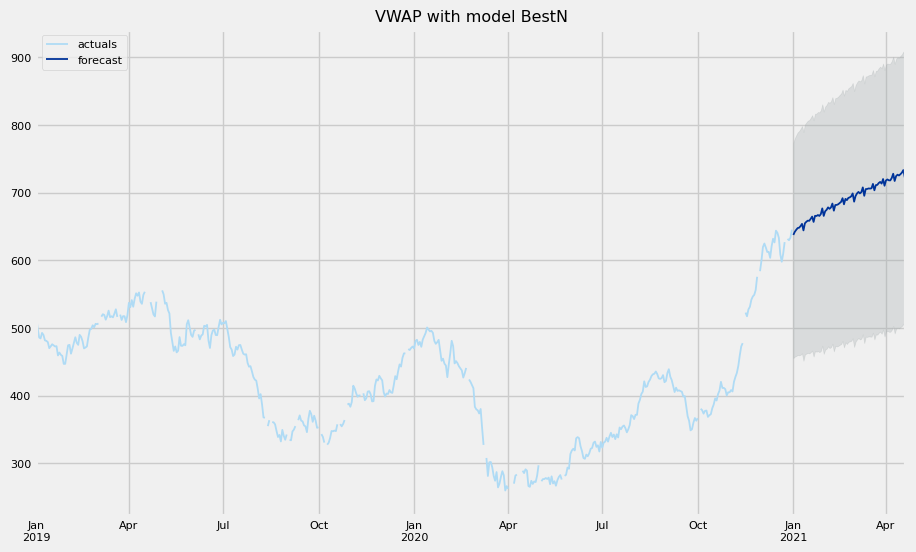

In [11]:
# Generate predictions
prediction = model.predict()
# Plot sample
prediction.plot(model.df_wide_numeric,
               series=model.df_wide_numeric.columns[0],
               start_date="2019-01-01");

In [12]:
# Details of the best model
print(model)

Initiated AutoTS object with best model: 
Ensemble
{}
{'model_name': 'BestN', 'model_count': 3, 'model_metric': 'horizontal', 'models': {'ae08bf5d8b76e05dd42e67540c2fef39': {'Model': 'ETS', 'ModelParameters': '{"damped_trend": true, "trend": "additive", "seasonal": "additive", "seasonal_periods": 7}', 'TransformationParameters': '{"fillna": "cubic", "transformations": {"0": "SeasonalDifference", "1": "MinMaxScaler", "2": "SeasonalDifference", "3": "Slice", "4": "SeasonalDifference"}, "transformation_params": {"0": {"lag_1": 12, "method": "Median"}, "1": {}, "2": {"lag_1": 7, "method": "LastValue"}, "3": {"method": 100}, "4": {"lag_1": 7, "method": "Median"}}}'}, '1ff427ac15eac567c36afe899d39d435': {'Model': 'GLM', 'ModelParameters': '{"family": "Binomial", "constant": false, "regression_type": null}', 'TransformationParameters': '{"fillna": "ffill", "transformations": {"0": "RobustScaler", "1": "MaxAbsScaler", "2": "SeasonalDifference", "3": "AlignLastDiff"}, "transformation_params": {

In [13]:
# Generate point forecasts
forecasts_df = prediction.forecast

# Upper and lower bounds
forecast_u, forecast_l = prediction.upper_forecast, prediction.lower_forecast

In [14]:
# model results
model_results = model.results()
model_results.head(5)

,ID,Model,ModelParameters,TransformationParameters,TransformationRuntime,FitRuntime,PredictRuntime,TotalRuntime,Ensemble,Exceptions,...,oda_weighted,dwae_weighted,mqae_weighted,ewmae_weighted,uwmse_weighted,smoothness_weighted,wasserstein_weighted,dwd_weighted,TotalRuntimeSeconds,Score
82,9c1271c8ec59812d1cbbad3e75c16a49,Theta,"{""deseasonalize"": true, ""difference"": false, ""...","{""fillna"": ""ffill"", ""transformations"": {""0"": ""...",0 days 00:00:00.007603,0 days 00:00:00.000010,0 days 00:00:00.112355,0 days 00:00:00.122501,0,NaN,...,0.556962,15.220762,57.059988,269.751475,1023.582970,1.217178,309.202908,26.172808,0.1225,12.221254
92,61a78102fcfe6216786de70984a3147c,Ensemble,"{""model_name"": ""BestN"", ""model_count"": 3, ""mod...",{},0 days 00:00:00,0 days 00:00:00.266320,0 days 00:00:00.000875,0 days 00:00:00.272544,1,NaN,...,0.556962,15.219058,57.062269,269.801452,1023.927355,1.217178,309.135462,26.174292,0.2725,12.222047
83,e16268ecb7482da80f9868a9e628171d,Theta,"{""deseasonalize"": true, ""difference"": false, ""...","{""fillna"": ""ffill"", ""transformations"": {""0"": ""...",0 days 00:00:00.007269,0 days 00:00:00.000013,0 days 00:00:00.112958,0 days 00:00:00.121942,0,NaN,...,0.556962,15.218206,57.063409,269.826441,1024.099602,1.217178,309.101739,26.175035,0.1219,12.222398
74,fcebca4186c7506b773bb60899b59da9,Theta,"{""deseasonalize"": true, ""difference"": false, ""...","{""fillna"": ""ffill"", ""transformations"": {""0"": ""...",0 days 00:00:00.003397,0 days 00:00:00.000017,0 days 00:00:00.025707,0 days 00:00:00.031149,0,NaN,...,0.556962,15.218206,57.063409,269.826441,1024.099602,1.217178,309.101739,26.175035,0.0311,12.222409
93,34f6d3d3926a05fc3fd6928c8d964ad8,Ensemble,"{""model_name"": ""BestN"", ""model_count"": 5, ""mod...",{},0 days 00:00:00,0 days 00:00:00.413071,0 days 00:00:00.000226,0 days 00:00:00.419675,1,NaN,...,0.556962,15.218207,57.063435,269.826464,1024.099627,1.217165,309.102021,26.175038,0.4197,12.222455


In [15]:
rmse(forecasts_df, df_test.VWAP)

102.9244

**-PROSE-**

## **Darts** BUGGY / BROKEN -  Revisit

**-PROSE-**

In [31]:
#from darts.models import Prophet, ExponentialSmoothing, AutoARIMA, Theta, RegressionEnsembleModel, RegressionModel

## **GluonTS**

**-PROSE-**

In [34]:
# setup the data and align the lengths for simplicity

df1 = pd.read_csv("data/hourly-energy-consumption/COMED_hourly.csv",parse_dates = True)
df1 = df1.loc[df1["Datetime"] > '2011-12-31'].reset_index(drop = True)

df2 = pd.read_csv("data/hourly-energy-consumption/DOM_hourly.csv",parse_dates = True)
df2 = df2.loc[df2["Datetime"] > '2011-12-31'].reset_index(drop = True)

df3 = pd.read_csv("data/hourly-energy-consumption/PJME_hourly.csv",parse_dates = True)
df3 = df3.loc[df3["Datetime"] > '2011-12-31'].reset_index(drop = True)

In [35]:
# DeepAR requires the conversion of dataframes from long to wide
def format_df(df):
    xname = df.columns[1][:-3]
    df = df.T
    df.columns = df.iloc[0]
    df = df.drop(df.index[0])
    df['Station_Name'] = xname
    df = df.reset_index(drop=True)
    return df

In [37]:
df1 = format_df(df1)
df2 = format_df(df2)
df3 = format_df(df3)

# Merge all
df_all = pd.concat([df1, df2, df3], axis=0)
df_all = df_all.set_index("Station_Name")
df_all = df_all.reset_index()

# Grouping variable for DeepAR
ts = df_all["Station_Name"].astype('category').cat.codes.values
ts

array([0, 0, 0, ..., 0, 0, 0], dtype=int8)

In [38]:
df1.head()

2011-12-31 01:00:00,9970.0,Station_Name
0,9428.0,2011-12-31 02:00
1,9059.0,2011-12-31 02:00
2,8817.0,2011-12-31 02:00
3,8743.0,2011-12-31 02:00
4,8735.0,2011-12-31 02:00
